In [9]:
import librosa
import pandas as pd
import requests
import csv
import torch
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import logging

from torch.utils.tensorboard import SummaryWriter

In [43]:
import requests
from bs4 import BeautifulSoup
import csv
import time

class FreesoundParser:
    def __init__(self, base_url, max_pages=20):
        self.base_url = base_url
        self.max_pages = max_pages
        self.audio_links = []

    def fetch_audio_links(self, search_query, page_number):
        url = f"{self.base_url}/search/?q={search_query}+&page={page_number}#sound"
        print(f"Загружаем страницу: {url}")

        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")

        cards = soup.find_all("div", class_="bw-player")
        for card in cards:
            audio_link = card.get("data-mp3")
            if audio_link:
                self.audio_links.append({"Gender": search_query, "Audio Link": audio_link})

    def save_links_to_csv(self, filename):
        with open(filename, "w", newline="", encoding="utf-8") as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=["Gender", "Audio Link"])
            writer.writeheader()
            writer.writerows(self.audio_links)

    def run(self, queries):
        for query in queries:
            for page_number in range(1, self.max_pages + 1):
                try:
                    self.fetch_audio_links(query, page_number)
                    time.sleep(1) 
                except Exception as e:
                    break
        print(f"Всего собрано {len(self.audio_links)} аудиофайлов.")
        
        self.save_links_to_csv("audio_links.csv")

if __name__ == "__main__":
    base_url = "https://freesound.org"
    queries = ["male", "female"]

    parser = FreesoundParser(base_url, max_pages=20)
    parser.run(queries)


Начинаем сбор данных для запроса: male
Загружаем страницу: https://freesound.org/search/?q=male+&page=1#sound
Найдено 15 аудио на странице.
Загружаем страницу: https://freesound.org/search/?q=male+&page=2#sound
Найдено 15 аудио на странице.
Загружаем страницу: https://freesound.org/search/?q=male+&page=3#sound
Найдено 15 аудио на странице.
Загружаем страницу: https://freesound.org/search/?q=male+&page=4#sound
Найдено 15 аудио на странице.
Загружаем страницу: https://freesound.org/search/?q=male+&page=5#sound
Найдено 15 аудио на странице.
Загружаем страницу: https://freesound.org/search/?q=male+&page=6#sound
Найдено 15 аудио на странице.
Загружаем страницу: https://freesound.org/search/?q=male+&page=7#sound
Найдено 15 аудио на странице.
Загружаем страницу: https://freesound.org/search/?q=male+&page=8#sound
Найдено 15 аудио на странице.
Загружаем страницу: https://freesound.org/search/?q=male+&page=9#sound
Найдено 15 аудио на странице.
Загружаем страницу: https://freesound.org/search/?q=

In [45]:
df = pd.read_csv("audio_links.csv")
df.head()

,Gender,Audio Link
0,male,https://cdn.freesound.org/previews/744/744403_...
1,male,https://cdn.freesound.org/previews/509/509880_...
2,male,https://cdn.freesound.org/previews/464/464239_...
3,male,https://cdn.freesound.org/previews/318/318087_...
4,male,https://cdn.freesound.org/previews/718/718958_...


In [14]:
class AudioProcessor:
    def __init__(self, csv_file, output_dir="processed_audio", sr=16000):
        self.csv_file = csv_file
        self.output_dir = output_dir
        self.sr = sr
        os.makedirs(self.output_dir, exist_ok=True)

    def process_audio(self):
        data = pd.read_csv(self.csv_file)
        mfcc_features = []
        labels = []
        for _, row in data.iterrows():
            gender = row["Gender"]
            url = row["Audio Link"]
            try:
                response = requests.get(url, stream=True)
                response.raise_for_status()
                audio_path = os.path.join(self.output_dir, f"{gender}_{os.path.basename(url).split('.')[0]}.wav")
                with open(audio_path, "wb") as audio_file:
                    for chunk in response.iter_content(chunk_size=8192):
                        audio_file.write(chunk)
                audio, _ = librosa.load(audio_path, sr=self.sr)
                if len(audio) < 5 * self.sr:
                    continue
                audio = audio[:5 * self.sr]
                mfcc = librosa.feature.mfcc(y=audio, sr=self.sr, n_mfcc=13)
                mfcc_features.append(mfcc.T)
                labels.append(0 if gender == "male" else 1)
                os.remove(audio_path)
            except Exception as e:
                logging.error(f"Error processing {url}: {e}")
        return mfcc_features, labels

In [15]:
class AudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = [torch.tensor(f, dtype=torch.float32) for f in features]
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [32]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim * 2, 1)

    def forward(self, lstm_out):
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        attention_weights = attention_weights.transpose(1, 2)
        weighted_sum = torch.bmm(attention_weights, lstm_out)
        return weighted_sum.squeeze(1)

In [45]:
class RNNTextClassificationModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, bidirectional=True, dropout=0.3):
        super(RNNTextClassificationModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.batchNorm = nn.BatchNorm1d(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, return_embedding=False):
        lstm_out, _ = self.lstm(x)
        attention_out = self.attention(lstm_out)
        attention_out = self.batchNorm(attention_out)
        attention_out = self.dropout(attention_out)
        if return_embedding:
            return attention_out
        return self.fc(attention_out).squeeze(1)

In [17]:
csv_file = "audio_links.csv"

processor = AudioProcessor(csv_file)
mfcc_features, labels = processor.process_audio()

In [40]:
X_train, X_test, y_train, y_test = train_test_split(mfcc_features, labels, test_size=0.2, random_state=42)
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

ValueError: Found input variables with inconsistent numbers of samples: [343, 5]

In [47]:
input_dim = 13
hidden_dim = 64
output_dim = 1
model = RNNTextClassificationModel(input_dim, hidden_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

writer = SummaryWriter()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [57]:
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    avg_loss = train_loss / len(train_loader)
    train_accuracy = train_correct / train_total
    writer.add_scalar('Loss/Train', avg_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
    print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {avg_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")

    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = test_correct / test_total
    writer.add_scalar('Loss/Test', avg_test_loss, epoch)
    writer.add_scalar('Accuracy/Test', test_accuracy, epoch)
    print(f"Epoch {epoch + 1}/{epochs} | Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

Epoch 1/20 | Train Loss: 0.0505 | Train Accuracy: 0.9745
Epoch 1/20 | Test Loss: 1.6824 | Test Accuracy: 0.7101
Epoch 2/20 | Train Loss: 0.0667 | Train Accuracy: 0.9781
Epoch 2/20 | Test Loss: 1.5592 | Test Accuracy: 0.7246
Epoch 3/20 | Train Loss: 0.1270 | Train Accuracy: 0.9599
Epoch 3/20 | Test Loss: 1.1714 | Test Accuracy: 0.7391
Epoch 4/20 | Train Loss: 0.0893 | Train Accuracy: 0.9562
Epoch 4/20 | Test Loss: 1.3675 | Test Accuracy: 0.7536
Epoch 5/20 | Train Loss: 0.0932 | Train Accuracy: 0.9635
Epoch 5/20 | Test Loss: 1.4566 | Test Accuracy: 0.6957
Epoch 6/20 | Train Loss: 0.0447 | Train Accuracy: 0.9891
Epoch 6/20 | Test Loss: 1.1887 | Test Accuracy: 0.7536
Epoch 7/20 | Train Loss: 0.0522 | Train Accuracy: 0.9891
Epoch 7/20 | Test Loss: 1.1903 | Test Accuracy: 0.7681
Epoch 8/20 | Train Loss: 0.0585 | Train Accuracy: 0.9781
Epoch 8/20 | Test Loss: 1.3250 | Test Accuracy: 0.7101
Epoch 9/20 | Train Loss: 0.0360 | Train Accuracy: 0.9891
Epoch 9/20 | Test Loss: 1.3401 | Test Accuracy:

In [58]:
model.eval()
all_preds = []
all_targets = []
embeddings = []
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = torch.sigmoid(model(features))
        preds = (outputs >= 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())
        embeddings.append(model(features, return_embedding=True).cpu().numpy())

print("Classification Report:")
print(classification_report(all_targets, all_preds, digits=4))
logging.info("Classification Report:\n" + classification_report(all_targets, all_preds, digits=4))

Classification Report:
              precision    recall  f1-score   support

         0.0     0.8000    0.6667    0.7273        36
         1.0     0.6923    0.8182    0.7500        33

    accuracy                         0.7391        69
   macro avg     0.7462    0.7424    0.7386        69
weighted avg     0.7485    0.7391    0.7381        69



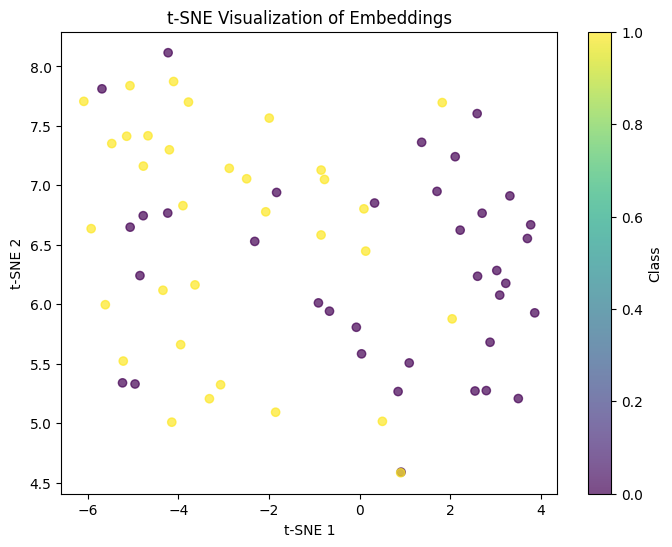

In [59]:
embeddings = np.concatenate(embeddings, axis=0)

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=all_targets, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Class")
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.savefig("tsne_embeddings.png")
plt.show()

writer.close()